Epochs = 1, MAE = 1.0806
Epochs = 5, MAE = 1.0224
Epochs = 10, MAE = 1.0215
Epochs = 50, MAE = 1.0811
Epochs = 100, MAE = 1.1025


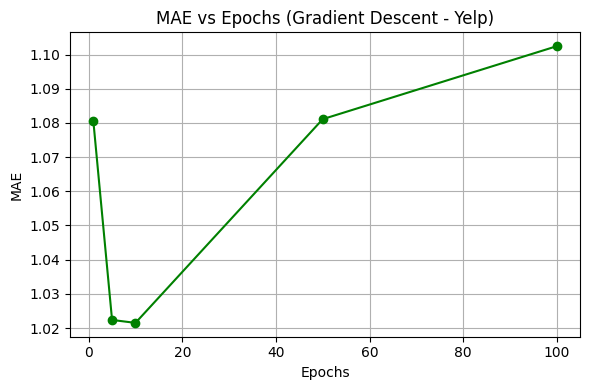

In [3]:
# Baseline Model (mu + bu + bi) with Gradient Descent - Yelp Dataset

import pandas as pd
import numpy as np
import time
from scipy import sparse
import matplotlib.pyplot as plt

# Load and split Yelp data
def load_and_split_yelp_data():
    ratings_df = pd.read_csv('ratings.csv')
    ratings_df['Date'] = pd.to_datetime(ratings_df['Date'])
    ratings_df = ratings_df.sort_values(['User ID', 'Date'])

    unique_users = sorted(ratings_df['User ID'].unique())
    unique_businesses = sorted(ratings_df['Business ID'].unique())

    user_to_idx = {user_id: idx for idx, user_id in enumerate(unique_users)}
    business_to_idx = {business_id: idx for idx, business_id in enumerate(unique_businesses)}

    train_data = []
    test_data = []

    for user_id in unique_users:
        user_ratings = ratings_df[ratings_df['User ID'] == user_id].copy()
        n_ratings = len(user_ratings)

        if n_ratings == 1:
            train_data.extend(user_ratings.values.tolist())
        else:
            n_train = int(np.floor(n_ratings * 0.8))
            train_ratings = user_ratings.iloc[:n_train]
            test_ratings = user_ratings.iloc[n_train:]
            train_data.extend(train_ratings.values.tolist())
            test_data.extend(test_ratings.values.tolist())

    train_df = pd.DataFrame(train_data, columns=['User ID', 'Business ID', 'Rating', 'Date'])
    test_df = pd.DataFrame(test_data, columns=['User ID', 'Business ID', 'Rating', 'Date'])

    return train_df, test_df, user_to_idx, business_to_idx, len(unique_users), len(unique_businesses)

# Create sparse matrices
def create_sparse_matrices(train_df, test_df, user_to_idx, business_to_idx, num_users, num_businesses):
    train_user_indices = [user_to_idx[uid] for uid in train_df['User ID']]
    train_business_indices = [business_to_idx[bid] for bid in train_df['Business ID']]
    train_ratings = train_df['Rating'].values

    sp_training = sparse.csr_matrix(
        (train_ratings, (train_user_indices, train_business_indices)),
        shape=(num_users, num_businesses),
        dtype=np.float64
    )

    test_user_indices = [user_to_idx[uid] for uid in test_df['User ID']]
    test_business_indices = [business_to_idx[bid] for bid in test_df['Business ID']]
    test_ratings = test_df['Rating'].values

    sp_test = sparse.csr_matrix(
        (test_ratings, (test_user_indices, test_business_indices)),
        shape=(num_users, num_businesses),
        dtype=np.float64
    )

    return
    sp_training,
    sp_test,
    train_user_indices,
    train_business_indices,
    train_ratings, num_users,
    num_businesses

# Predict using baseline formula
def predict(user, item):
    return mu + bu[user] + bi[item]

# Compute MAE
def computeMAE():
    MAE = 0.0
    rows, cols = sp_test.nonzero()
    for j in range(len(rows)):
        actual = sp_test[rows[j], cols[j]]
        predicted = predict(rows[j], cols[j])
        MAE += abs(actual - predicted)
    MAE /= len(rows)
    return MAE

# Main
if __name__ == '__main__':
    train_df, test_df, user_to_idx, business_to_idx, num_users, num_items = load_and_split_yelp_data()
    sp_training, sp_test, train_user_indices, train_item_indices, train_ratings, num_users, num_items = create_sparse_matrices(
        train_df, test_df, user_to_idx, business_to_idx, num_users, num_items)

    mu = sp_training.data.mean()

    # Parameters
    lr = 0.05
    reg = 0.02
    epoch_list = [1, 5, 10, 50, 100]
    mae_list = []

    for epochs in epoch_list:
        bu = np.zeros(num_users)
        bi = np.zeros(num_items)

        for epoch in range(epochs):
            for u, i, r in zip(train_user_indices, train_item_indices, train_ratings):
                pred = mu + bu[u] + bi[i]
                err = r - pred
                bu[u] += lr * (err - reg * bu[u])
                bi[i] += lr * (err - reg * bi[i])

        mae = computeMAE()
        print(f"Epochs = {epochs}, MAE = {mae:.4f}")
        mae_list.append(mae)

    # Plot MAE vs Epochs
    plt.figure(figsize=(6, 4))
    plt.plot(epoch_list, mae_list, marker='o', color='green')
    plt.title('MAE vs Epochs (Gradient Descent - Yelp)')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.grid(True)
    plt.tight_layout()
    plt.show()